# Set-up

In [1]:
# imports
import os
import sys
import numpy as np
import pandas as pd
import scanpy as sc
import mudata
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib_venn import venn3

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
path_out = "/cellar/users/aklie/data/datasets/tf_perturb_seq/datasets/Gersbach_WTC11-benchmark_TF-Perturb-seq_GEM-Xv3/results/1_CRISPR_pipeline/2026_01_06"

os.makedirs(path_out, exist_ok=True)

# Load MuData

In [3]:
path_mdata = "/cellar/users/aklie/data/datasets/tf_perturb_seq/datasets/Gersbach_WTC11-benchmark_TF-Perturb-seq_GEM-Xv3/results/1_CRISPR_pipeline/2026_01_06/inference_mudata.h5mu"

In [4]:
mdata = mudata.read_h5mu(path_mdata)
mdata

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py311/lib/python3.11/site-packages/mudata/_core/mudata.py:1598: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py311/lib/python3.11/site-packages/mudata/_core/mudata.py:1461: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


MuData object with n_obs × n_vars = 57672 × 14428
  obs:	'cov1', 'batch'
  uns:	'cis_per_element_results', 'cis_per_guide_results', 'trans_per_element_results', 'trans_per_guide_results'
  2 modalities
    gene:	57672 x 14012
      obs:	'batch', 'cov1', 'batch_number', 'n_counts', 'log1p_n_genes_by_counts', 'total_gene_umis', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'percent_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'num_expressed_genes'
      var:	'symbol', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'gene_chr', 'gene_start', 'gene_end'
    guide:	57672 x 416
      obs:	'batch', 'cov1', 'num_expressed_guides', 'total_guide_umis'
      var:	'guide_id', 'spacer', 'targeting', 'type', 'guide_chr', 'guide_start', 'guide_end', 'strand', 'pam', 'genomic_element', 'intended_target_name', 'intended_target_chr', 'intended_target_start', 'intended_target_end', 'putative_target_genes', 'reporter', 'imperfect', 'gene_name', 'label'
      uns:	'capture_method', 'moi'
      layers:	'guide_assignment'

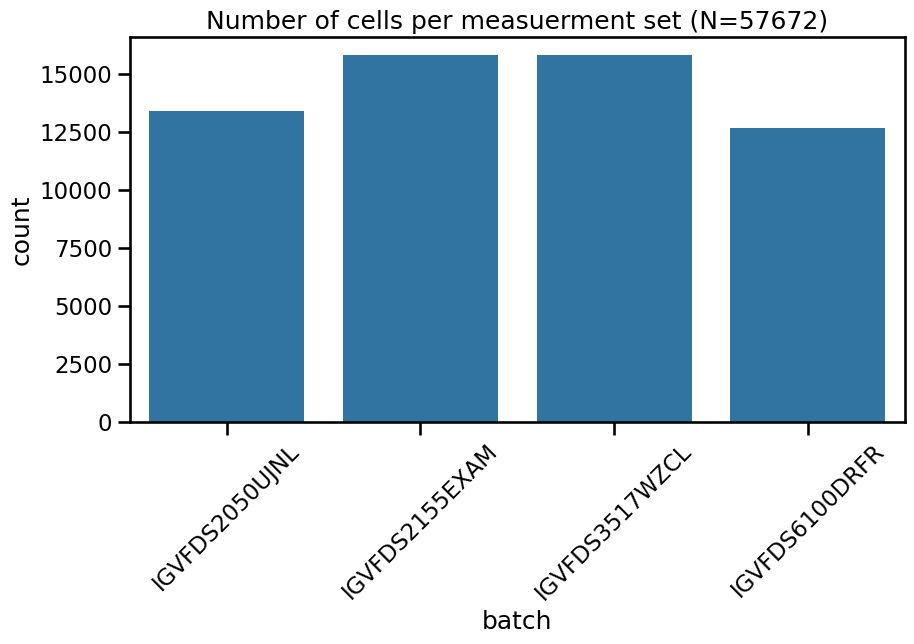

<Figure size 640x480 with 0 Axes>

In [5]:
# Plot the number of cells per batch
with sns.plotting_context("talk"):
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.countplot(x="batch", data=mdata.obs, ax=ax)
    ax.set_title(f"Number of cells per measuerment set (N={mdata.n_obs})")

    # rotate x labels
    plt.xticks(rotation=45)
    plt.show()
    
    plt.tight_layout()

# Transcriptome QC

In [6]:
gene = mdata["gene"]
gene

AnnData object with n_obs × n_vars = 57672 × 14012
    obs: 'batch', 'cov1', 'batch_number', 'n_counts', 'log1p_n_genes_by_counts', 'total_gene_umis', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'percent_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'num_expressed_genes'
    var: 'symbol', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'gene_chr', 'gene_start', 'gene_end'

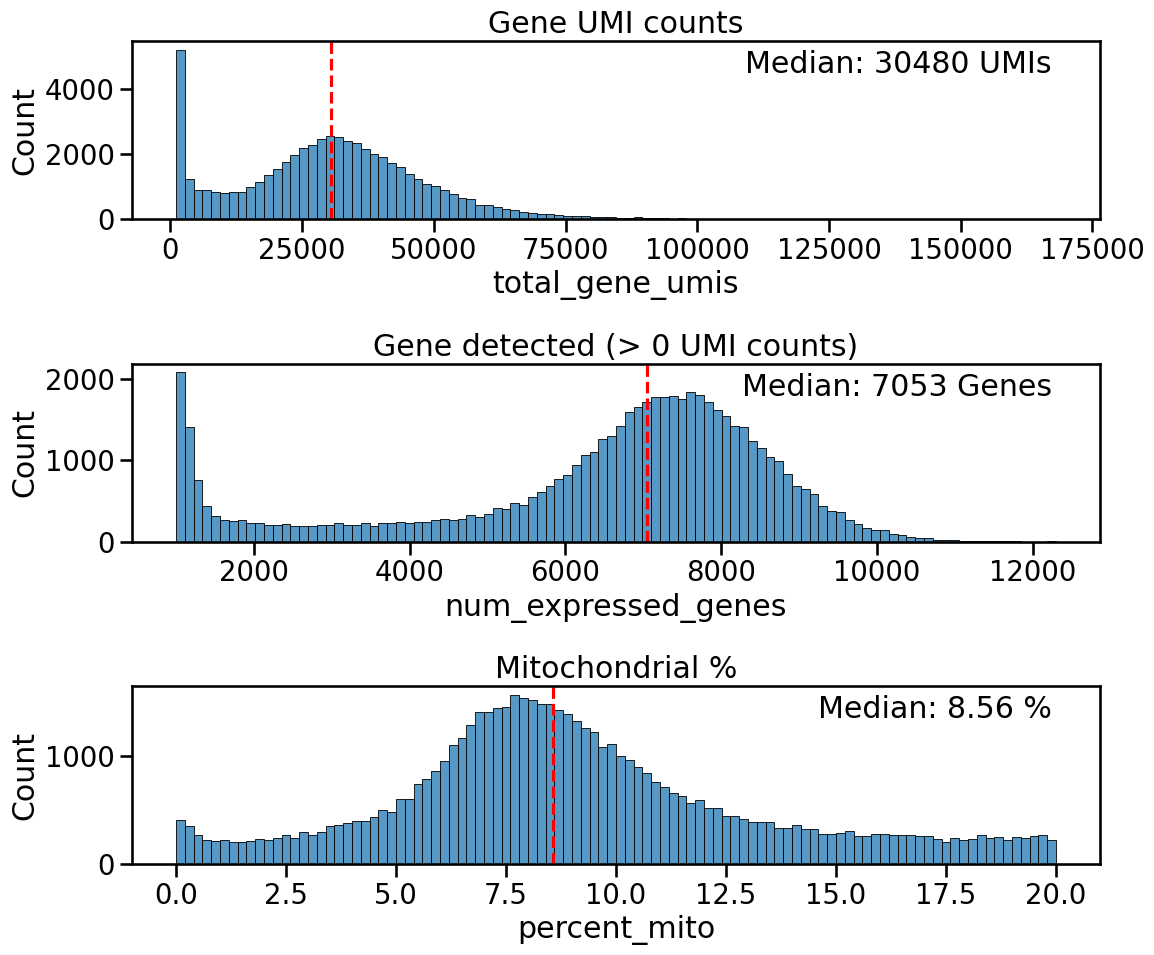

In [7]:
# Like these better: plot the distribution of UMI counts and annotate with median (red dashed line and text in upper right corner)
with sns.plotting_context("talk", font_scale=1.2):
    fig, ax = plt.subplots(3, 1, figsize=(12, 10))

    # Plotting total counts
    sns.histplot(gene.obs["total_gene_umis"], bins=100, ax=ax[0])
    ax[0].axvline(gene.obs["total_gene_umis"].median(), color="red", linestyle="--")
    ax[0].text(0.95, 0.95, f"Median: {gene.obs['total_gene_umis'].median():.0f} UMIs", ha="right", va="top", transform=ax[0].transAxes)
    ax[0].set_title("Gene UMI counts")

    # Plotting percentage of mitochondrial genes
    sns.histplot(gene.obs["num_expressed_genes"], bins=100, ax=ax[1])
    ax[1].axvline(gene.obs["num_expressed_genes"].median(), color="red", linestyle="--")
    ax[1].text(0.95, 0.95, f"Median: {gene.obs['num_expressed_genes'].median():.0f} Genes", ha="right", va="top", transform=ax[1].transAxes)
    ax[1].set_title("Gene detected (> 0 UMI counts)")

    # Plotting percentage of mitochondrial genes
    sns.histplot(gene.obs["percent_mito"], bins=100, ax=ax[2])
    ax[2].axvline(gene.obs["percent_mito"].median(), color="red", linestyle="--")
    ax[2].text(0.95, 0.95, f"Median: {gene.obs['percent_mito'].median():.2f} %", ha="right", va="top", transform=ax[2].transAxes)
    ax[2].set_title("Mitochondrial %")

    plt.tight_layout()
    plt.show()

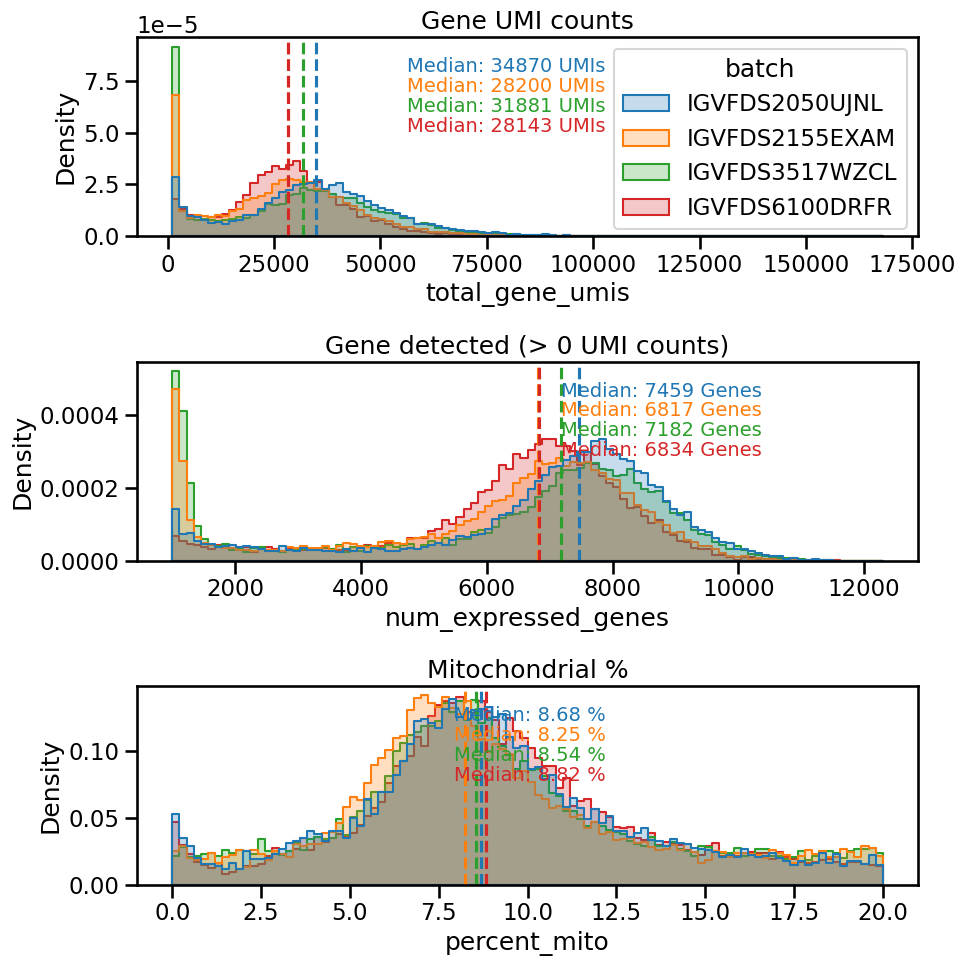

In [8]:
# Split the above by batch with different colors, add dotted lines for medians, one legend to right of plots
batch_colors = sns.color_palette("tab10", n_colors=gene.obs["batch"].nunique())
batch_color_dict = dict(zip(gene.obs["batch"].unique(), batch_colors))

with sns.plotting_context("talk", font_scale=1):
    fig, ax = plt.subplots(3, 1, figsize=(10, 10))

    # Plotting total counts
    sns.histplot(data=gene.obs, x="total_gene_umis", bins=100, hue="batch", palette=batch_color_dict, ax=ax[0], element="step", stat="density", common_norm=False)
    for batch in gene.obs["batch"].unique():
        median_val = gene.obs.loc[gene.obs["batch"] == batch, "total_gene_umis"].median()
        ax[0].axvline(median_val, color=batch_color_dict[batch], linestyle="--")
        ax[0].text(0.6, 0.9 - 0.1 * list(gene.obs["batch"].unique()).index(batch), f"Median: {median_val:.0f} UMIs", ha="right", va="top", transform=ax[0].transAxes, color=batch_color_dict[batch], fontsize=14)
    ax[0].set_title("Gene UMI counts")

    # Plotting number of expressed genes
    sns.histplot(data=gene.obs, x="num_expressed_genes", bins=100, hue="batch", palette=batch_color_dict, ax=ax[1], element="step", stat="density", common_norm=False)
    for batch in gene.obs["batch"].unique():
        median_val = gene.obs.loc[gene.obs["batch"] == batch, "num_expressed_genes"].median()
        ax[1].axvline(median_val, color=batch_color_dict[batch], linestyle="--")
        ax[1].text(0.8, 0.9 - 0.1 * list(gene.obs["batch"].unique()).index(batch), f"Median: {median_val:.0f} Genes", ha="right", va="top", transform=ax[1].transAxes, color=batch_color_dict[batch], fontsize=14)
    ax[1].set_title("Gene detected (> 0 UMI counts)")
    ax[1].legend_.remove()

    # Plotting percentage of mitochondrial genes
    sns.histplot(data=gene.obs, x="percent_mito", bins=100, hue="batch", palette=batch_color_dict, ax=ax[2], element="step", stat="density", common_norm=False)
    for batch in gene.obs["batch"].unique():
        median_val = gene.obs.loc[gene.obs["batch"] == batch, "percent_mito"].median()
        ax[2].axvline(median_val, color=batch_color_dict[batch], linestyle="--")
        ax[2].text(0.6, 0.9 - 0.1 * list(gene.obs["batch"].unique()).index(batch), f"Median: {median_val:.2f} %", ha="right", va="top", transform=ax[2].transAxes, color=batch_color_dict[batch], fontsize=14)
    ax[2].set_title("Mitochondrial %")
    ax[2].legend_.remove()

    plt.tight_layout()
    plt.show()

# Guide 

In [9]:
guide = mdata["guide"]
guide

AnnData object with n_obs × n_vars = 57672 × 416
    obs: 'batch', 'cov1', 'num_expressed_guides', 'total_guide_umis'
    var: 'guide_id', 'spacer', 'targeting', 'type', 'guide_chr', 'guide_start', 'guide_end', 'strand', 'pam', 'genomic_element', 'intended_target_name', 'intended_target_chr', 'intended_target_start', 'intended_target_end', 'putative_target_genes', 'reporter', 'imperfect', 'gene_name', 'label'
    uns: 'capture_method', 'moi'
    layers: 'guide_assignment'

In [10]:
# Calculate n_guides_per_cell and n_cells_per_guide from layers["guide_assignment"]
guide.obs["n_guides_per_cell"] = np.sum(guide.layers["guide_assignment"] > 0, axis=1).A1
guide.var["n_cells_per_guide"] = np.sum(guide.layers["guide_assignment"] > 0, axis=0).A1

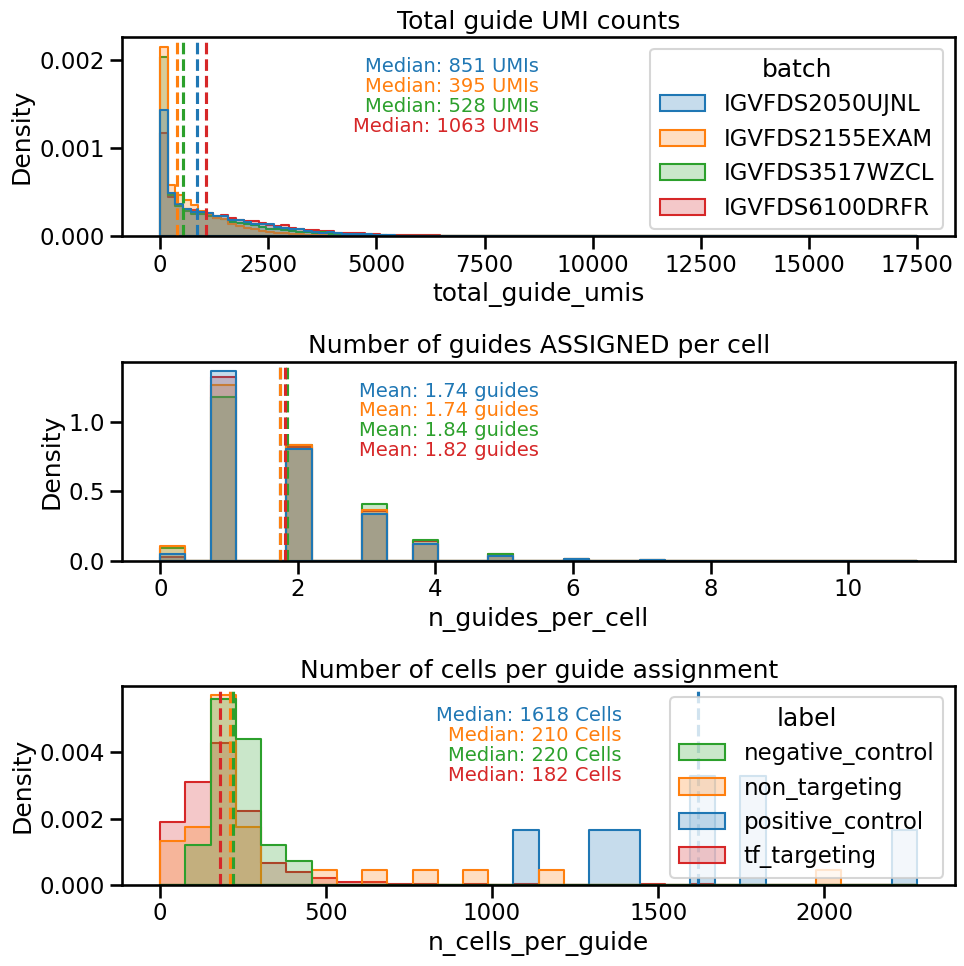

In [11]:
# Plot the distribution of UMI counts and annotate with median (red dashed line and text in upper right corner)
guide_label_colors = sns.color_palette("tab10", n_colors=guide.var["label"].nunique())
guide_label_color_dict = dict(zip(guide.var["label"].unique(), guide_label_colors))

with sns.plotting_context("talk", font_scale=1):
    

    fig, ax = plt.subplots(3, 1, figsize=(10, 10))

    # Guide umis per cell
    sns.histplot(data=guide.obs, x="total_guide_umis", bins=100, hue="batch", palette=batch_color_dict, ax=ax[0], element="step", stat="density", common_norm=False)
    for batch in guide.obs["batch"].unique():
        median_val = guide.obs.loc[guide.obs["batch"] == batch, "total_guide_umis"].median()
        ax[0].axvline(median_val, color=batch_color_dict[batch], linestyle="--")
        ax[0].text(0.5, 0.9 - 0.1 * list(guide.obs["batch"].unique()).index(batch), f"Median: {median_val:.0f} UMIs", ha="right", va="top", transform=ax[0].transAxes, color=batch_color_dict[batch], fontsize=14)
    ax[0].set_title("Total guide UMI counts")
        
    # n_guides_per_cell
    sns.histplot(data=guide.obs, x="n_guides_per_cell", bins=30, hue="batch", palette=batch_color_dict, ax=ax[1], element="step", stat="density", common_norm=False)
    for batch in guide.obs["batch"].unique():
        mean_val = guide.obs.loc[guide.obs["batch"] == batch, "n_guides_per_cell"].mean()
        ax[1].axvline(mean_val, color=batch_color_dict[batch], linestyle="--")
        ax[1].text(0.5, 0.9 - 0.1 * list(guide.obs["batch"].unique()).index(batch), f"Mean: {mean_val:.2f} guides", ha="right", va="top", transform=ax[1].transAxes, color=batch_color_dict[batch], fontsize=14)
    ax[1].set_title("Number of guides ASSIGNED per cell")
    ax[1].legend_.remove()

    # n_cells_per_guide
    sns.histplot(data=guide.var, x="n_cells_per_guide", bins=30, hue="label", palette=guide_label_color_dict, ax=ax[2], element="step", stat="density", common_norm=False)
    median_val = guide.var["n_cells_per_guide"].median()
    for label in guide.var["label"].unique():
        median_val = guide.var.loc[guide.var["label"] == label, "n_cells_per_guide"].median()
        ax[2].axvline(median_val, color=guide_label_color_dict[label], linestyle="--")
        ax[2].text(0.6, 0.9 - 0.1 * list(guide.var["label"].unique()).index(label), f"Median: {median_val:.0f} Cells", ha="right", va="top", transform=ax[2].transAxes, color=guide_label_color_dict[label], fontsize=14)
    ax[2].set_title("Number of cells per guide assignment")

    plt.tight_layout()
    plt.show()

# DONE!

---